In [38]:
from __future__ import annotations

import importlib
import pathlib

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import polars
import theme
from plotly.subplots import make_subplots

importlib.reload(theme)

<module 'theme' from '/home/jgpaul/workspace/sc24-proxystore-analysis/notebooks/theme.py'>

In [34]:
def load_data(directory):
    data = polars.read_csv(pathlib.Path(directory) / 'results.csv')

    data = data.with_columns(
        (polars.col('workflow_makespan_ms') / 1000).alias(
            'workflow_makespan_s',
        ),
    )
    data = data.with_columns(
        polars.when(polars.col('submission_method') == 'sequential')
        .then(polars.col('task_sleep') * polars.col('task_chain_length'))
        .otherwise(
            (1 - polars.col('task_overhead_fraction'))
            * polars.col('task_sleep')
            * polars.col('task_chain_length'),
        )
        .alias('limit'),
    )

    return data

In [42]:
def create_trend_figure(data, layout=None):
    fig = go.Figure()

    colors = px.colors.qualitative.Bold[0:2]
    markers = ('circle', 'diamond')

    for i, deployment in enumerate(('Sequential', 'Pipelined')):
        subdata = data.filter(
            polars.col('submission_method') == deployment.lower(),
        )

        scatter_data = go.Scatter(
            x=subdata['task_overhead_fraction'],
            y=subdata['workflow_makespan_s'],
            name=deployment,
            line=dict(color=colors[i]),
            mode='lines+markers',
            marker=dict(symbol=markers[i], size=10),
        )
        scatter_limit = go.Scatter(
            x=subdata['task_overhead_fraction'],
            y=subdata['limit'],
            name=f'{deployment} Limit',
            line=dict(color=colors[i], dash='dash'),
            mode='lines',
        )

        fig.add_trace(scatter_data)
        fig.add_trace(scatter_limit)

    layout = {} if layout is None else layout
    fig.update_layout(
        # title={'text': 'Task Pipelining with Futures'},
        xaxis_title='Task Overhead Fraction',
        yaxis_title='Makespan (s)',
        yaxis={'tickformat': '.0f'},
        legend=dict(yanchor='bottom', y=0.02, xanchor='left', x=0.01),
        template='proxystore',
        **layout,
    )

    return fig

In [43]:
def extract_timestamps(data, sections):
    assert len(data) == 1

    timestamps = data['task_timestamps'].item()
    timestamps = timestamps.split(':')
    timestamps = [sorted(float(x) for x in t.split('-')) for t in timestamps]
    timestamps = sorted(timestamps, key=lambda x: x[0])

    start_timestamp = timestamps[0][0]
    timestamps = [[v - start_timestamp for v in t] for t in timestamps]

    parts = []
    for task_index, timestamp in enumerate(timestamps):
        assert len(timestamp) == len(sections) + 1
        for i, section in enumerate(sections):
            start = timestamp[i]
            end = timestamp[i + 1]
            part = dict(
                Task=task_index % 4,
                Start=start,
                Finish=end,
                delta=end - start,
                section=section,
            )
            parts.append(part)

    return parts  # polars.DataFrame(parts)


def create_timeline_figure(data, layout=None):
    sections = (
        'submit',
        'overhead',
        'resolve',
        'compute',
        'generate',
        'receive',
    )
    sample_types = (
        ('sequential', 0.1),
        ('pipelined', 0.1),
        ('pipelined', 0.5),
    )

    fig = make_subplots(
        cols=1,
        rows=len(sample_types),
        vertical_spacing=0.04,
        shared_xaxes=True,
    )

    max_x_range = 0
    for row, (deployment, overhead) in enumerate(sample_types):
        subsamples = data.filter(
            polars.col('submission_method') == deployment,
        ).filter(polars.col('task_overhead_fraction') == overhead)
        subsample = subsamples.sample(1)
        timestamps = list(reversed(extract_timestamps(subsample, sections)))

        timeline_fig = ff.create_gantt(
            timestamps,
            index_col='section',
            show_colorbar=False,
            group_tasks=True,
            bar_width=0.4,
            colors=[px.colors.qualitative.Bold[i] for i in [1, 2, 0, 3, 4, 5]],
        )

        # Crazy hacks to add traces in right order for legend
        traces = list(timeline_fig.data)
        for section in sections:
            for trace in traces:
                if trace.name == section:
                    fig.add_trace(trace, row=row + 1, col=1)
                    traces.remove(trace)
                    break
        for trace in traces:
            fig.add_trace(trace, row=row + 1, col=1)
        fig.update_yaxes(
            title_text=f'{deployment}<br>Overhead = {overhead}',
            title_font=dict(size=11),
            showticklabels=False,
            ticks='',
            row=row + 1,
            col=1,
        )
        max_x_range = max(max_x_range, timestamps[0]['Finish'])
        if row + 1 == len(sample_types):
            fig.update_xaxes(
                title_text='Runtime (s)',
                range=[0, max_x_range],
                row=row + 1,
                col=1,
            )

    fig.update_traces(showlegend=True)
    names = set()
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=False)
        if trace.name == '' or trace.name in names
        else names.add(trace.name),
    )

    layout = {} if layout is None else layout
    fig.update_layout(
        # title={'text': 'Task Pipelining with Futures'},
        legend=dict(
            yanchor='bottom', y=0.02, xanchor='right', x=0.99, tracegroupgap=4,
        ),
        template='proxystore',
        **layout,
    )

    return fig

## Alderaan Testing Run

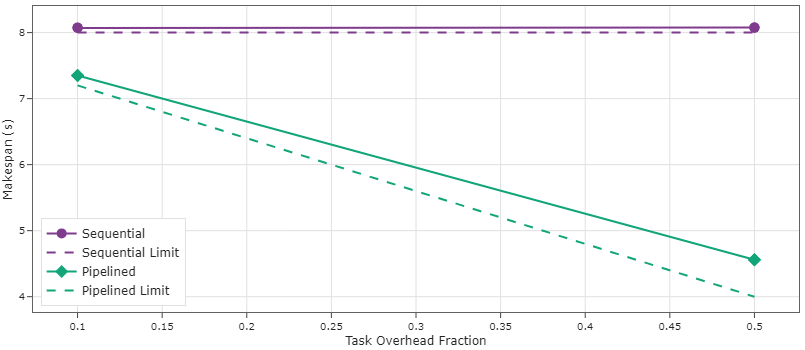

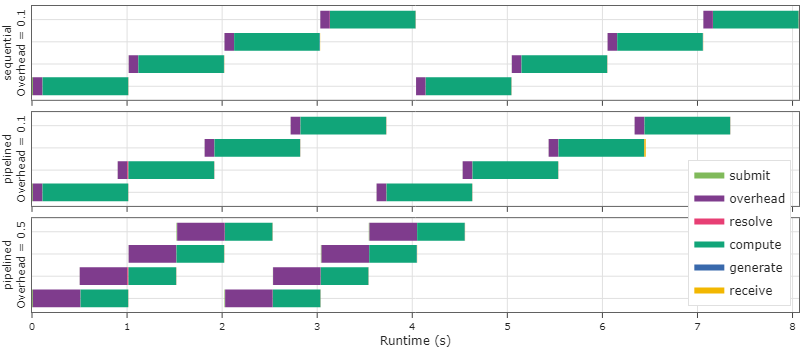

In [44]:
data = load_data('../data/alderaan/task-pipelining-2024-03-07-10-54-21')

layout = dict(width=800, height=350)

trend_fig = create_trend_figure(data, layout)
timeline_fig = create_timeline_figure(data, layout)

trend_fig.show()
timeline_fig.show()

figure_dir = pathlib.Path('../figures/alderaan/')
figure_dir.mkdir(exist_ok=True)

trend_fig.write_image(figure_dir / '0-task-pipelining-trend.pdf')
timeline_fig.write_image(figure_dir / '0-task-pipelining-timeline.pdf')